# Feature engineering
------------------------------

This example shows how to use automated feature generation to improve a model's performance.

The data used is a variation on the [Australian weather dataset](https://www.kaggle.com/jsphyg/weather-dataset-rattle-package) from Kaggle. You can download it from [here](https://github.com/tvdboom/ATOM/blob/master/examples/datasets/weatherAUS.csv). The goal of this dataset is to predict whether or not it will rain tomorrow training a binary classifier on target `RainTomorrow`.

## Load the data

In [1]:
# Import packages
import pandas as pd
from atom import ATOMClassifier

In [2]:
# Load data
X = pd.read_csv("./datasets/weatherAUS.csv")

# Let's have a look
X.head()

,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,WindDir3pm,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,MelbourneAirport,18.0,26.9,21.4,7.0,8.9,SSE,41.0,W,SSE,...,95.0,54.0,1019.5,1017.0,8.0,5.0,18.5,26.0,Yes,0
1,Adelaide,17.2,23.4,0.0,NaN,NaN,S,41.0,S,WSW,...,59.0,36.0,1015.7,1015.7,NaN,NaN,17.7,21.9,No,0
2,Cairns,18.6,24.6,7.4,3.0,6.1,SSE,54.0,SSE,SE,...,78.0,57.0,1018.7,1016.6,3.0,3.0,20.8,24.1,Yes,0
3,Portland,13.6,16.8,4.2,1.2,0.0,ESE,39.0,ESE,ESE,...,76.0,74.0,1021.4,1020.5,7.0,8.0,15.6,16.0,Yes,1
4,Walpole,16.4,19.9,0.0,NaN,NaN,SE,44.0,SE,SE,...,78.0,70.0,1019.4,1018.9,NaN,NaN,17.4,18.1,No,0


## Run the pipeline

In [3]:
# Initialize atom and apply data cleaning
atom = ATOMClassifier(X, n_rows=1e4, test_size=0.2, warnings=False, verbose=0)
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)
atom.encode(max_onehot=10, frac_to_other=0.04)

In [4]:
atom.verbose = 2  # Increase verbosity to see the output

# Let's see how a LightGBM model performs
atom.run('LGB', metric='auc')


Training ========================= >>
Models: LGB
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9829
Test evaluation --> roc_auc: 0.8684
Time elapsed: 0.285s
-------------------------------------------------
Total time: 0.285s


Final results ==================== >>
Duration: 0.285s
-------------------------------------
LightGBM --> roc_auc: 0.8684


## Deep Feature Synthesis

In [5]:
# Since we are going to compare different datasets,
# we need to create separate branches
atom.branch = "dfs"

New branch dfs successfully created.


In [6]:
# Create 50 new features using DFS
atom.feature_generation("dfs", n_features=50, operators=["add", "sub", "log"])

Fitting FeatureGenerator...
Creating new features...
 --> 50 new features were added.


In [7]:
# The warnings warn us that some operators created missing values!
# We can see the columns with missing values using the nans attribute
atom.nans

LOG(Sunshine)    148
dtype: int64

In [8]:
# Turn off warnings in the future
atom.warnings = False

# Impute the data again to get rid of the missing values
atom.impute(strat_num="knn", strat_cat="remove", max_nan_rows=0.8)

Fitting Imputer...
Imputing missing values...
 --> Imputing 148 missing values using the KNN imputer in feature LOG(Sunshine).


In [9]:
# 50 new features may be to much...
# Let's check for multicollinearity and use RFECV to reduce the number
atom.feature_selection(
    strategy="RFECV",
    solver="LGB",
    n_features=30,
    scoring="auc",
    max_correlation=0.98,
)

Fitting FeatureSelector...
Performing feature selection ...
 --> Feature Location was removed due to low variance. Value 0.12987012987012986 repeated in 506798.0% of the rows.
 --> Feature Cloud3pm + RainToday_Yes was removed due to collinearity with another feature.
 --> Feature Cloud3pm - RainToday_No was removed due to collinearity with another feature.
 --> Feature Cloud3pm - RainToday_other was removed due to collinearity with another feature.
 --> Feature Cloud9am + Humidity3pm was removed due to collinearity with another feature.
 --> Feature Cloud9am + WindGustDir was removed due to collinearity with another feature.
 --> Feature Cloud9am - RainToday_other was removed due to collinearity with another feature.
 --> Feature Cloud9am - WindDir3pm was removed due to collinearity with another feature.
 --> Feature Evaporation + WindDir9am was removed due to collinearity with another feature.
 --> Feature Humidity3pm + RainToday_No was removed due to collinearity with another feature

In [10]:
# The collinear attribute shows what features were removed due to multicollinearity
atom.collinear

,drop_feature,correlated_feature,correlation_value
0,Cloud3pm + RainToday_Yes,Cloud3pm,0.98395
1,Cloud3pm - RainToday_No,"Cloud3pm, Cloud3pm + RainToday_Yes","0.9837, 0.99946"
2,Cloud3pm - RainToday_other,"Cloud3pm, Cloud3pm + RainToday_Yes, Cloud3pm -...","0.99939, 0.98364, 0.98222"
3,Cloud9am + Humidity3pm,Humidity3pm,0.99517
4,Cloud9am + WindGustDir,Cloud9am,0.99978
5,Cloud9am - RainToday_other,"Cloud9am, Cloud9am + WindGustDir","0.99948, 0.99926"
6,Cloud9am - WindDir3pm,"Cloud9am, Cloud9am + WindGustDir, Cloud9am - R...","0.99979, 0.99938, 0.99927"
7,Evaporation + WindDir9am,Evaporation,0.99988
8,Humidity3pm + RainToday_No,"Humidity3pm, Cloud9am + Humidity3pm","0.99982, 0.99477"
9,Humidity9am + RainToday_No,Humidity9am,0.99979


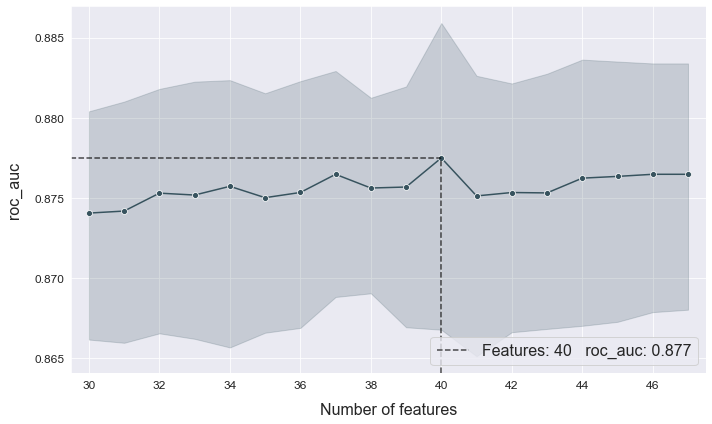

In [11]:
# After applying RFECV, we can plot the score per number of features
atom.plot_rfecv()

In [12]:
# Let's see how the model performs now
# Add a tag to the model's acronym to not overwrite previous LGB
atom.run("LGB_dfs")


Training ========================= >>
Models: LGB_dfs
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9959
Test evaluation --> roc_auc: 0.8761
Time elapsed: 0.503s
-------------------------------------------------
Total time: 0.503s


Final results ==================== >>
Duration: 0.503s
-------------------------------------
LightGBM --> roc_auc: 0.8761


## Genetic Feature Generation

In [13]:
# Create another branch for the genetic features
# Split form master to avoid the dfs features
atom.branch = "gfg_from_master"

New branch gfg successfully created.


In [14]:
# Create new features using Genetic Programming
atom.feature_generation(strategy='GFG', n_features=20)

Fitting FeatureGenerator...
    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     3.10         0.131523        4         0.508444              N/A     18.68s
   1     3.01         0.343716        5         0.517489              N/A     19.12s
   2     3.55         0.425475        8         0.528016              N/A     17.39s
   3     4.31         0.448246        8         0.535803              N/A     17.79s
   4     6.32         0.426331       20         0.557325              N/A     15.30s
   5     8.77         0.442598       14         0.561713              N/A     14.63s
   6    10.73         0.455358       21         0.565327              N/A     13.84s
   7    13.14         0.469143       25         0.567983              N/A     13.02s
   8    15.02          0.50451       25        

In [15]:
# We can see the feature's fitness and description through the genetic_features attribute
atom.genetic_features

,name,description,fitness
0,feature 24,"mul(mul(add(WindGustSpeed, Humidity3pm), sub(C...",0.549676
1,feature 25,"mul(mul(add(WindGustSpeed, sub(Cloud3pm, sub(S...",0.549463
2,feature 26,"mul(mul(sub(Sunshine, add(WindGustSpeed, Humid...",0.550944
3,feature 27,"mul(mul(add(WindGustSpeed, Humidity3pm), sub(C...",0.551330
4,feature 28,"mul(add(WindGustSpeed, Humidity3pm), mul(sub(C...",0.551330
5,feature 29,"mul(mul(sub(Sunshine, add(WindGustSpeed, Humid...",0.551330


In [16]:
# Fit the model again
atom.run("LGB_gfg", metric="auc")


Training ========================= >>
Models: LGB_gfg
Metric: roc_auc


Results for LightGBM:
Fit ---------------------------------------------
Train evaluation --> roc_auc: 0.9849
Test evaluation --> roc_auc: 0.8694
Time elapsed: 0.336s
-------------------------------------------------
Total time: 0.336s


Final results ==================== >>
Duration: 0.338s
-------------------------------------
LightGBM --> roc_auc: 0.8694


## Analyze results

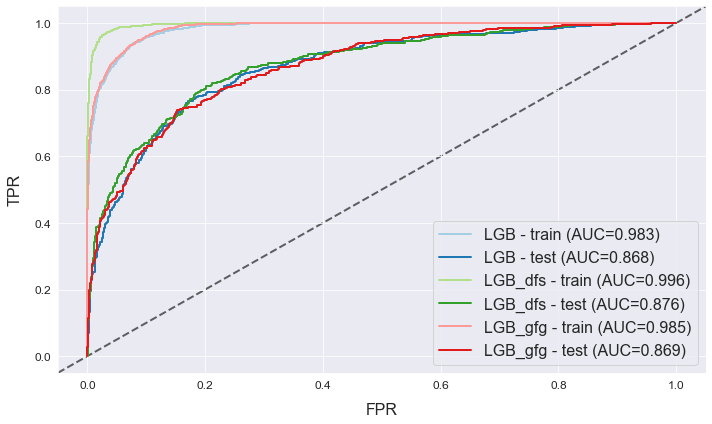

In [17]:
# Use atom's plots to compare the three models
atom.palette = "Paired"
atom.plot_roc(dataset="both")
atom.reset_aesthetics()

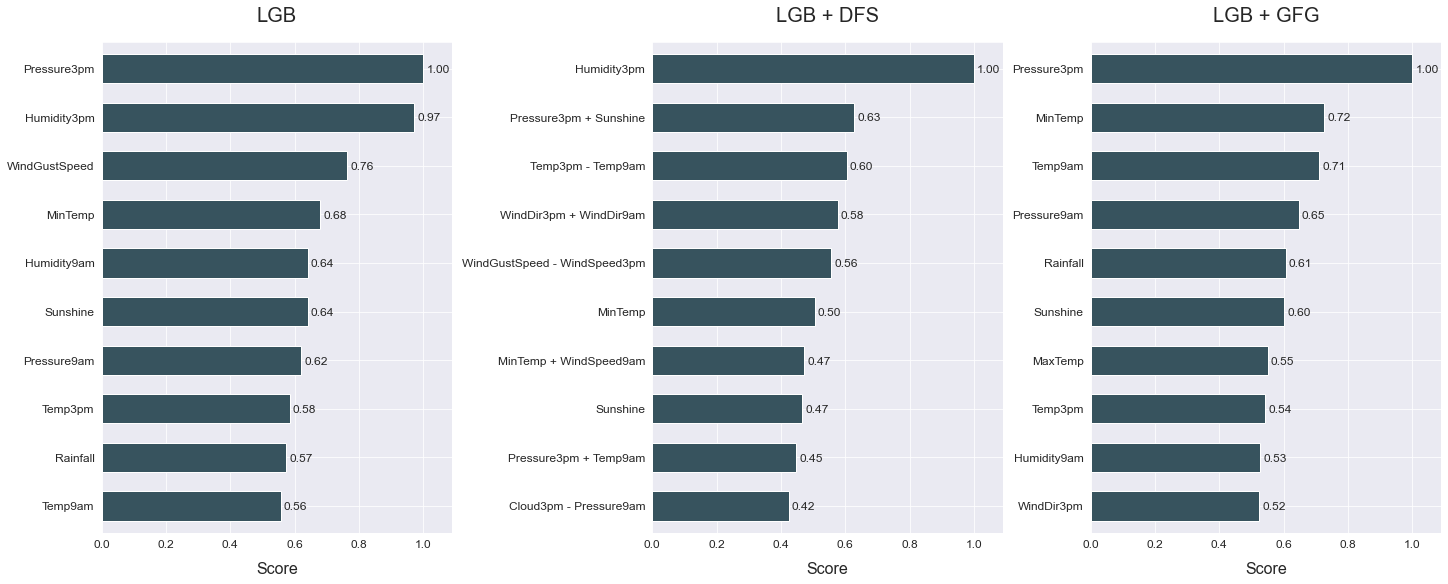

In [18]:
# For busy plots it might be useful to use a canvas
with atom.canvas(1, 3, figsize=(20, 8)):
    atom.lgb.plot_feature_importance(show=10, title="LGB")
    atom.lgb_dfs.plot_feature_importance(show=10, title="LGB + DFS")
    atom.lgb_gfg.plot_feature_importance(show=10, title="LGB + GFG")

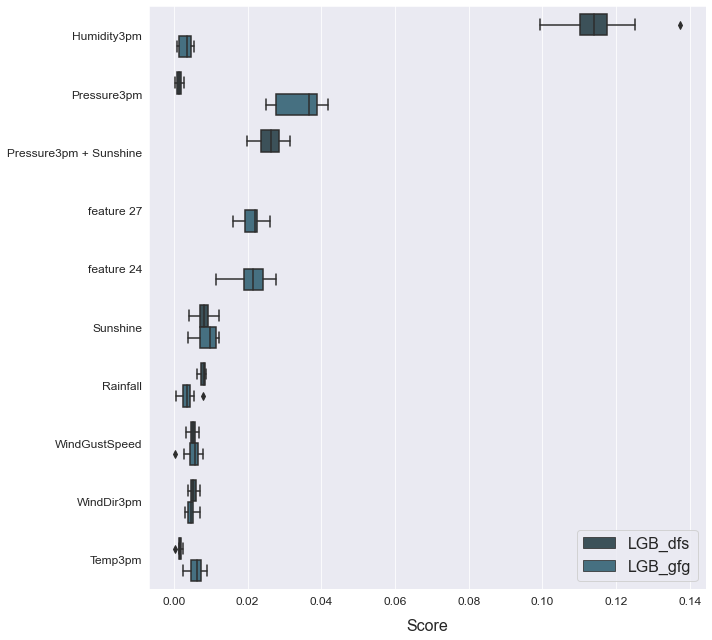

In [19]:
# We can check the feature importance with other plots as well
atom.plot_permutation_importance(models=["LGB_DFS", "LGB_GFG"], show=10)

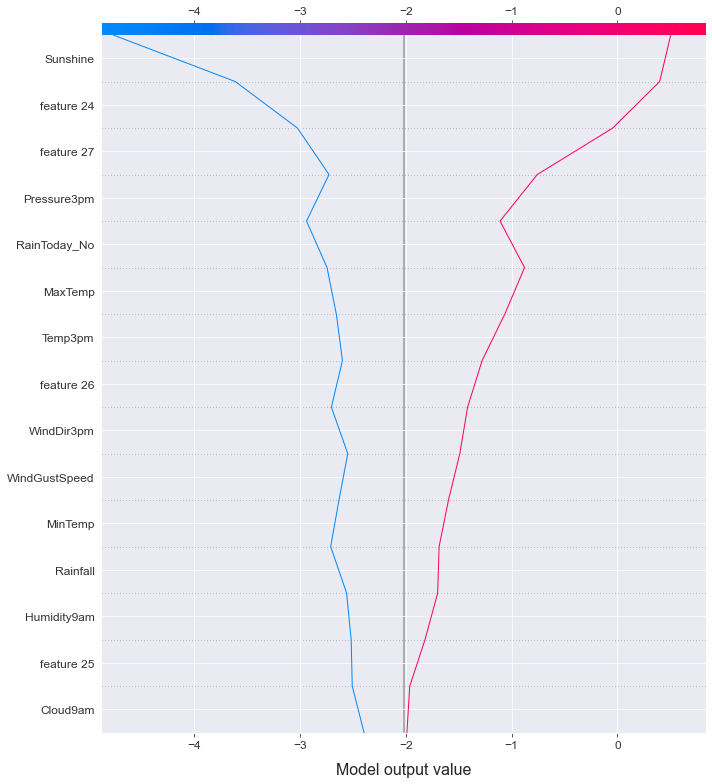

In [20]:
atom.LGB_gfg.decision_plot(index=(0, 10), show=15)